In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image  
import time

import torchvision
import torchvision.transforms as transforms
import torchvision.utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from utils import toumap, totsne, plotsmart
from utils import getallranks, calcmap
from utils import bestk_silhouette_score, getclusters_ws

from dataset import CustomDataset, DatasetFeatsTrain, dsbuild
from model import netmodel
from loss import HybridLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print('Using device:', torch.cuda.is_available(), torch.cuda.get_device_name(0))

Using device: True NVIDIA GeForce RTX 4090


# Feature Extraction

**Pre-traineded models**

In [2]:
netfeat = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
netfeat.to(device)
netfeat.eval()

def getfeat(x):
    with torch.no_grad():
        X = netfeat(x)
    return X

Using cache found in /home/de/.cache/torch/hub/facebookresearch_dinov2_main
/home/de/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/de/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/de/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [3]:
class ConvertTo3Channels:
    def __call__(self, img):
        # Se a imagem já tiver 3 canais, retorne-a como está
        if img.mode == "RGB":
            return img
        # Caso contrário, converta-a para RGB
        return img.convert("RGB")
    
transform = transforms.Compose(
    [
        ConvertTo3Channels(),
        transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ]
)

def configfeats(ds):
    with torch.no_grad():
        ds.feats = [[getfeat(d.unsqueeze(0).to(device))[0].cpu(), l] for d, l in ds]

ds = torchvision.datasets.CIFAR10('~/lab/ds',train = True, transform=transform, download=True)
dstest = torchvision.datasets.CIFAR10('~/lab/ds',train = False, transform=transform, download=True)

configfeats(ds)
configfeats(dstest)
len(ds.data)


Files already downloaded and verified
Files already downloaded and verified


50000

# Parametric TSNE

In [4]:
from ptsne import train_parametric_tsne_model
from ptsne.config import Config

config = Config()
print(f"Training on {config.dev}", flush=True)

Training on cuda


In [5]:
trainfs = [f for f, l in ds.feats]
trainlbs = [l for f, l in ds.feats]

In [6]:
from ptsne.ptsne_net import model

In [7]:
from torch.utils.data import TensorDataset

dim_input = trainfs[0].shape[0]
net = model(dim_input).to(device)

fs = torch.stack(trainfs).to(device)
lbs = torch.tensor(trainlbs)
trainset = TensorDataset(fs, lbs)
train_parametric_tsne_model(net, trainset, dim_input, config)

100%|██████████| 100/100 [00:06<00:00, 16.41it/s]

====> Epoch: 1. Time 0:00:06.096666. Average loss: 2.5548



100%|██████████| 100/100 [00:06<00:00, 15.90it/s]

====> Epoch: 2. Time 0:00:06.289583. Average loss: 0.8836



100%|██████████| 100/100 [00:04<00:00, 21.31it/s]

====> Epoch: 3. Time 0:00:04.693315. Average loss: 0.5597



100%|██████████| 100/100 [00:02<00:00, 44.55it/s]

====> Epoch: 4. Time 0:00:02.245420. Average loss: 0.3987



100%|██████████| 100/100 [00:05<00:00, 17.24it/s]

====> Epoch: 5. Time 0:00:05.800973. Average loss: 0.3043



100%|██████████| 100/100 [00:05<00:00, 19.38it/s]

====> Epoch: 6. Time 0:00:05.159831. Average loss: 0.2446



100%|██████████| 100/100 [00:06<00:00, 16.08it/s]

====> Epoch: 7. Time 0:00:06.218549. Average loss: 0.2019



100%|██████████| 100/100 [00:06<00:00, 16.33it/s]

====> Epoch: 8. Time 0:00:06.122756. Average loss: 0.1705



100%|██████████| 100/100 [00:06<00:00, 16.20it/s]

====> Epoch: 9. Time 0:00:06.171905. Average loss: 0.1471



100%|██████████| 100/100 [00:03<00:00, 26.78it/s]

====> Epoch: 10. Time 0:00:03.734157. Average loss: 0.1285
Training time: 0:00:52.534973


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


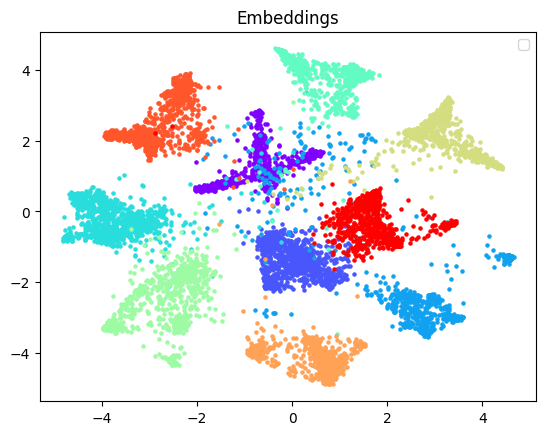

In [8]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)).cpu().squeeze() for f,l in dstest.feats], [l for f,l in dstest.feats]

plotsmart(np.array(fs), lbs, "Embeddings", True)

In [9]:
res = {}
ranks = getallranks(fs)
resmap = calcmap(ranks, lbs)
res['p-tsne'] = resmap
resmap

0.8774527343000545

# Parametric UMAP

In [10]:
import sys

try:
    from umap_pytorch import PUMAP
except ImportError:
    print("Pacote 'umap-pytorch' não encontrado. Instalando...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-pytorch"])
    from umap_pytorch import PUMAP 

pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

In [11]:
pumap.fit(torch.stack(trainfs))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Mon Dec 16 15:47:15 2024 Building RP forest with 16 trees
Mon Dec 16 15:47:17 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | default_encoder | 388 K  | train
----------------------------------------------------
388 K     Trainable params
0         Non-trainable params
388 K     Total params
1.553     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/de/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider incre

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reducing array of shape torch.Size([10000, 1536]) to (10000, 2)


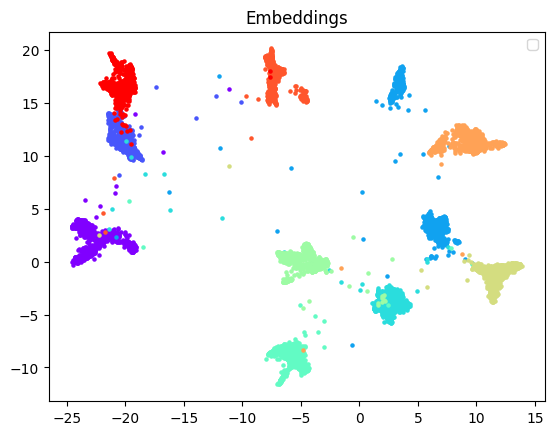

In [12]:
fs = [f for f, l in dstest.feats]
lbs = [l for f, l in dstest.feats]

embedding = pumap.transform(torch.stack(fs))
plotsmart(embedding, lbs, "Embeddings", True)

In [13]:
ranks = getallranks([torch.tensor(e) for e in embedding])
resmap = calcmap(ranks, lbs)
res['p-umap'] = resmap
resmap

0.9433626282290793

In [14]:
res

{'p-tsne': 0.8774527343000545, 'p-umap': 0.9433626282290793}